# **California Wildfire Prediction - Tabular Project**
## Mariah Noelle Cornelio

# ***FEASABILITY***

## **Define Project**

The goal of this project is to predict whether a wildfire will occur on a given day in California based on what the weather/humidity/wind speed/temperatures look like 30 days prior to a fire. This dataset uses historical environmental data in the state of California from 1984 to present day. 
- **Goal:** Create an algorithm that predicts when a fire will occur in a California region and provide analytics of weather patterns days prior to an event using LSTM. 
- **Project Link:** https://zenodo.org/records/14712845
- **Type of Machine Learning:** Supervised Binary Classification

## **Data Loading and Initial Look**

**Load the data and packages**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # For easy correlation plot
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv("/Users/marielle/Desktop/CA_Weather_Fire_Dataset_1984-2025.csv")
df.head(5)

,DATE,PRECIPITATION,MAX_TEMP,MIN_TEMP,AVG_WIND_SPEED,FIRE_START_DAY,YEAR,TEMP_RANGE,WIND_TEMP_RATIO,MONTH,SEASON,LAGGED_PRECIPITATION,LAGGED_AVG_WIND_SPEED,DAY_OF_YEAR
0,1/1/84,0.0,79.0,51.0,4.70,False,1984,28.0,0.059494,1,Winter,0.0,4.700,1
1,1/2/84,0.0,71.0,46.0,5.59,False,1984,25.0,0.078732,1,Winter,0.0,5.145,2
2,1/3/84,0.0,70.0,47.0,5.37,False,1984,23.0,0.076714,1,Winter,0.0,5.220,3
3,1/4/84,0.0,76.0,45.0,4.70,False,1984,31.0,0.061842,1,Winter,0.0,5.090,4
4,1/5/84,0.0,74.0,49.0,5.14,False,1984,25.0,0.069459,1,Winter,0.0,5.100,5


**Count the number of rows (data points) and features**

In [3]:
df.shape

# 14,988 rows and 14 columns

(14988, 14)

In [4]:
df.columns

# Description for each column can be found on the website source link above

Index(['DATE', 'PRECIPITATION', 'MAX_TEMP', 'MIN_TEMP', 'AVG_WIND_SPEED',
       'FIRE_START_DAY', 'YEAR', 'TEMP_RANGE', 'WIND_TEMP_RATIO', 'MONTH',
       'SEASON', 'LAGGED_PRECIPITATION', 'LAGGED_AVG_WIND_SPEED',
       'DAY_OF_YEAR'],
      dtype='object')

In [5]:
df.dtypes

DATE                      object
PRECIPITATION            float64
MAX_TEMP                 float64
MIN_TEMP                 float64
AVG_WIND_SPEED           float64
FIRE_START_DAY              bool
YEAR                       int64
TEMP_RANGE               float64
WIND_TEMP_RATIO          float64
MONTH                      int64
SEASON                    object
LAGGED_PRECIPITATION     float64
LAGGED_AVG_WIND_SPEED    float64
DAY_OF_YEAR                int64
dtype: object

From this, we'd want to move FIRE_START_DAY into the last column since it is our target variable and then change it into 0's and 1's since it is currently a boolean.

**Any missing values?**

In [6]:
df.isnull().sum()

# There are some null values we need to check out and address

DATE                      0
PRECIPITATION             1
MAX_TEMP                  1
MIN_TEMP                  1
AVG_WIND_SPEED           12
FIRE_START_DAY            0
YEAR                      0
TEMP_RANGE                1
WIND_TEMP_RATIO          12
MONTH                     0
SEASON                    0
LAGGED_PRECIPITATION      0
LAGGED_AVG_WIND_SPEED     0
DAY_OF_YEAR               0
dtype: int64

**Make a table, where each row is a feature or collection of features:**
- **Is the feature categorical or numerical**
- **What values? e.g. for categorical: "0,1,2", e.g. for numerical specify the range**
- **How many missing values**
- **Do you see any outliers? Define outlier.**

In [7]:
# IQR function to detect outliers
def detect_outliers(series):
    if not pd.api.types.is_numeric_dtype(series):
        return "N/A"
    # Drop NaNs first
    series = series.dropna()
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return ((series < lower) | (series > upper)).sum()

In [8]:
# Making the table
summary = []
for col in df.columns:
    series = df[col]
    n_missing = series.isnull().sum()
    unique_vals = series.dropna().unique()
    
    # Determine what the feature type is
    if pd.api.types.is_numeric_dtype(series) and not pd.api.types.is_bool_dtype(series):
        ftype = "Numerical"
        val_range = f"{series.min():.2f} to {series.max():.2f}"
        outliers = detect_outliers(series)
    elif pd.api.types.is_bool_dtype(series) or series.nunique() <= 10:
        ftype = "Categorical"
        val_range = ', '.join(map(str, sorted(series.dropna().unique())))
        outliers = "N/A"
    else:
        ftype = "Categorical"
        val_range = ', '.join(map(str, sorted(series.dropna().unique())[:5]))
        if series.nunique() > 5:
            val_range += ", ..."
        outliers = "N/A"

    summary.append({
        "Feature": col,
        "Type": ftype,
        "Values / Range": val_range,
        "Missing Values": n_missing,
        "Outliers": outliers})

summary_df = pd.DataFrame(summary)
summary_df

,Feature,Type,Values / Range,Missing Values,Outliers
0,DATE,Categorical,"1/1/00, 1/1/01, 1/1/02, 1/1/03, 1/1/04, ...",0,N/A
1,PRECIPITATION,Numerical,0.00 to 4.53,1,1381
2,MAX_TEMP,Numerical,50.00 to 106.00,1,161
3,MIN_TEMP,Numerical,33.00 to 77.00,1,2
4,AVG_WIND_SPEED,Numerical,1.79 to 26.17,12,479
5,FIRE_START_DAY,Categorical,"False, True",0,N/A
6,YEAR,Numerical,1984.00 to 2025.00,0,0
7,TEMP_RANGE,Numerical,2.00 to 41.00,1,573
8,WIND_TEMP_RATIO,Numerical,0.02 to 0.46,12,733
9,MONTH,Numerical,1.00 to 12.00,0,0


**For classification is there class imbalance?**

In [9]:
df['FIRE_START_DAY'].value_counts()
df['FIRE_START_DAY'].value_counts(normalize=True)  # as proportions

False    0.668335
True     0.331665
Name: FIRE_START_DAY, dtype: float64

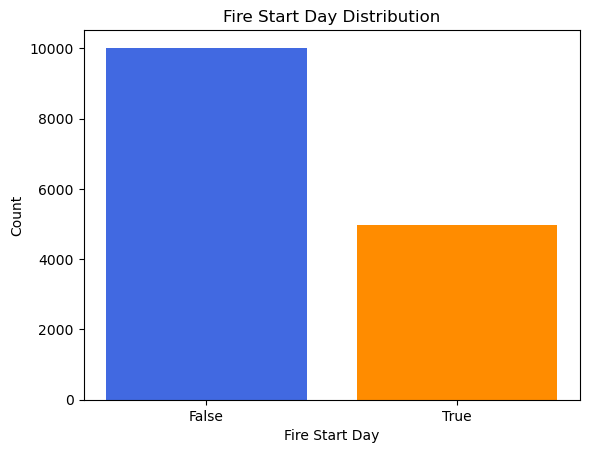

In [10]:
color_map = {True: 'darkorange', False: 'royalblue'}
fire_day_counts = df['FIRE_START_DAY'].value_counts().sort_index()
colors = [color_map[val] for val in fire_day_counts.index]

plt.bar(fire_day_counts.index.astype(str), fire_day_counts.values, color=colors)
plt.title('Fire Start Day Distribution')
plt.xlabel('Fire Start Day')
plt.ylabel('Count')
plt.show()

There seems to be a **moderate class imbalance** that we will have to consider when splitting and training our model. 66% false and 33% true.

**What is the target?**

- **Classification:** The target is encoded as True and False, so we will have to change that later to numerical values 0 and 1.

## **Data Visualization**

**Distribution of Features Against Class (0 and 1)**

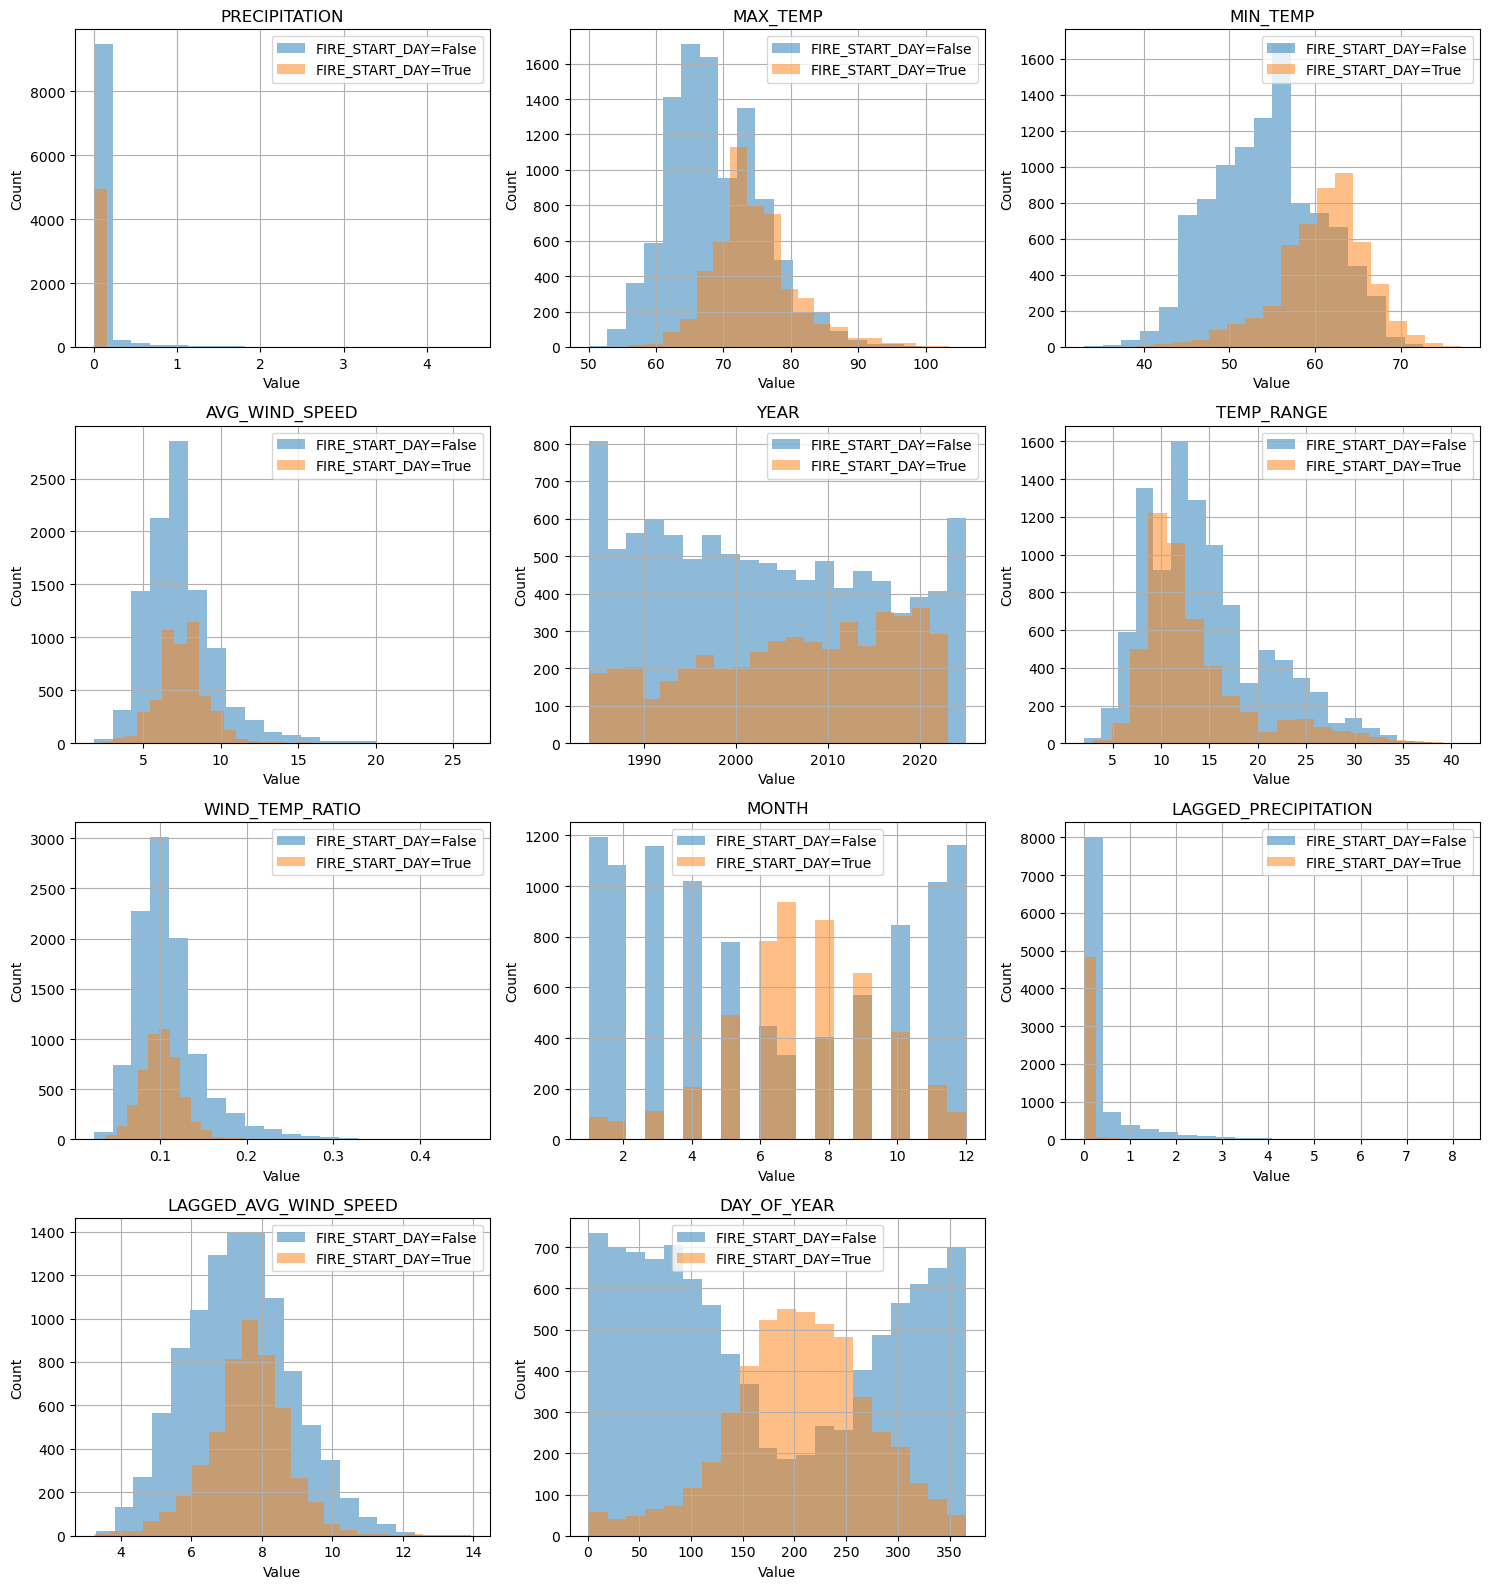

In [11]:
df['FIRE_START_DAY'] = df['FIRE_START_DAY'].astype(str)
numerical_features = df.select_dtypes(include='number').columns.tolist()

n_cols = 3  # number of plots per row
n_rows = (len(numerical_features) + n_cols - 1) // n_cols  # rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()

for idx, feature in enumerate(numerical_features):
    ax = axes[idx]
    for label in df['FIRE_START_DAY'].unique():
        subset = df[df['FIRE_START_DAY'] == label]
        ax.hist(subset[feature].dropna(), bins=20, alpha=0.5, label=f"FIRE_START_DAY={label}")
    
    ax.set_title(feature)
    ax.set_xlabel('Value')
    ax.set_ylabel('Count')
    ax.legend()
    ax.grid(True)

# Remove empty subplots if any
for i in range(len(numerical_features), len(axes)):
    fig.delaxes(axes[i])

fig.tight_layout()
plt.show()

**Analysis and Comparison of Distributions Against Classes:**

- Precipitation: Fires can start on days wheere it rains or doesn't rain
- Max_temp: There is a range of overlap in the 60s to high 80s where a fire may or may not start
- Min_temp: Fires don't usually happen on cooler days (< 55)
- Avg_wind_speed: You can see the class imbalance here but fire's will start when wind is present
- Year: The overall trend shows that the number of fires are increasing every year
- Temp_range: Shows that a fire has a higher chance of starting if the temp range between maximum and minimum temperature is higher
- Wind_temp_ratio: Wind and heat interaction can dry out vegetation, increasing the risk of fires
- Month: Fires happen exclusively in June to August but there is an overlap in range for the other months
- Lagged_precipitation: Fires usually start when there is no rain/no dampness
- Lagged_avg_wind_speed: Fires are most likely to occur with higher wind speeds
- Day_of_year: Same thing as Month

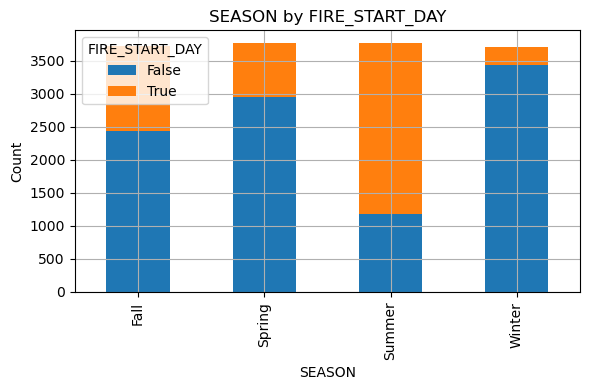

In [12]:
# For categorical features (just Season because we already visualized our target variable)

categorical_features=["SEASON"]

for feature in categorical_features:
    ct = pd.crosstab(df[feature], df['FIRE_START_DAY'])
    ct.plot(kind='bar', stacked=True, figsize=(6, 4))
    plt.title(f"{feature} by FIRE_START_DAY")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.legend(title="FIRE_START_DAY")
    plt.tight_layout()
    plt.grid(True)
    plt.show()

Fires usually start in the Summer > Fall > Spring > Winter

**Important features for my dataset that I want to use for machine learning:**
- MAX_TEMP
- MIN_TEMP
- WIND_TEMP_RATIO
- PRECIPITATION
- LAGGED PRECIPITATION
- AVG_WIND_SPEED
- LAGGED_AVG_WIND_SPEED
- TEMP_RANGE
- DATE (for LSTM)

**LSTM VISUALIZATION: An example of distributions of features across a timeframe of 30 days prior to a fire**

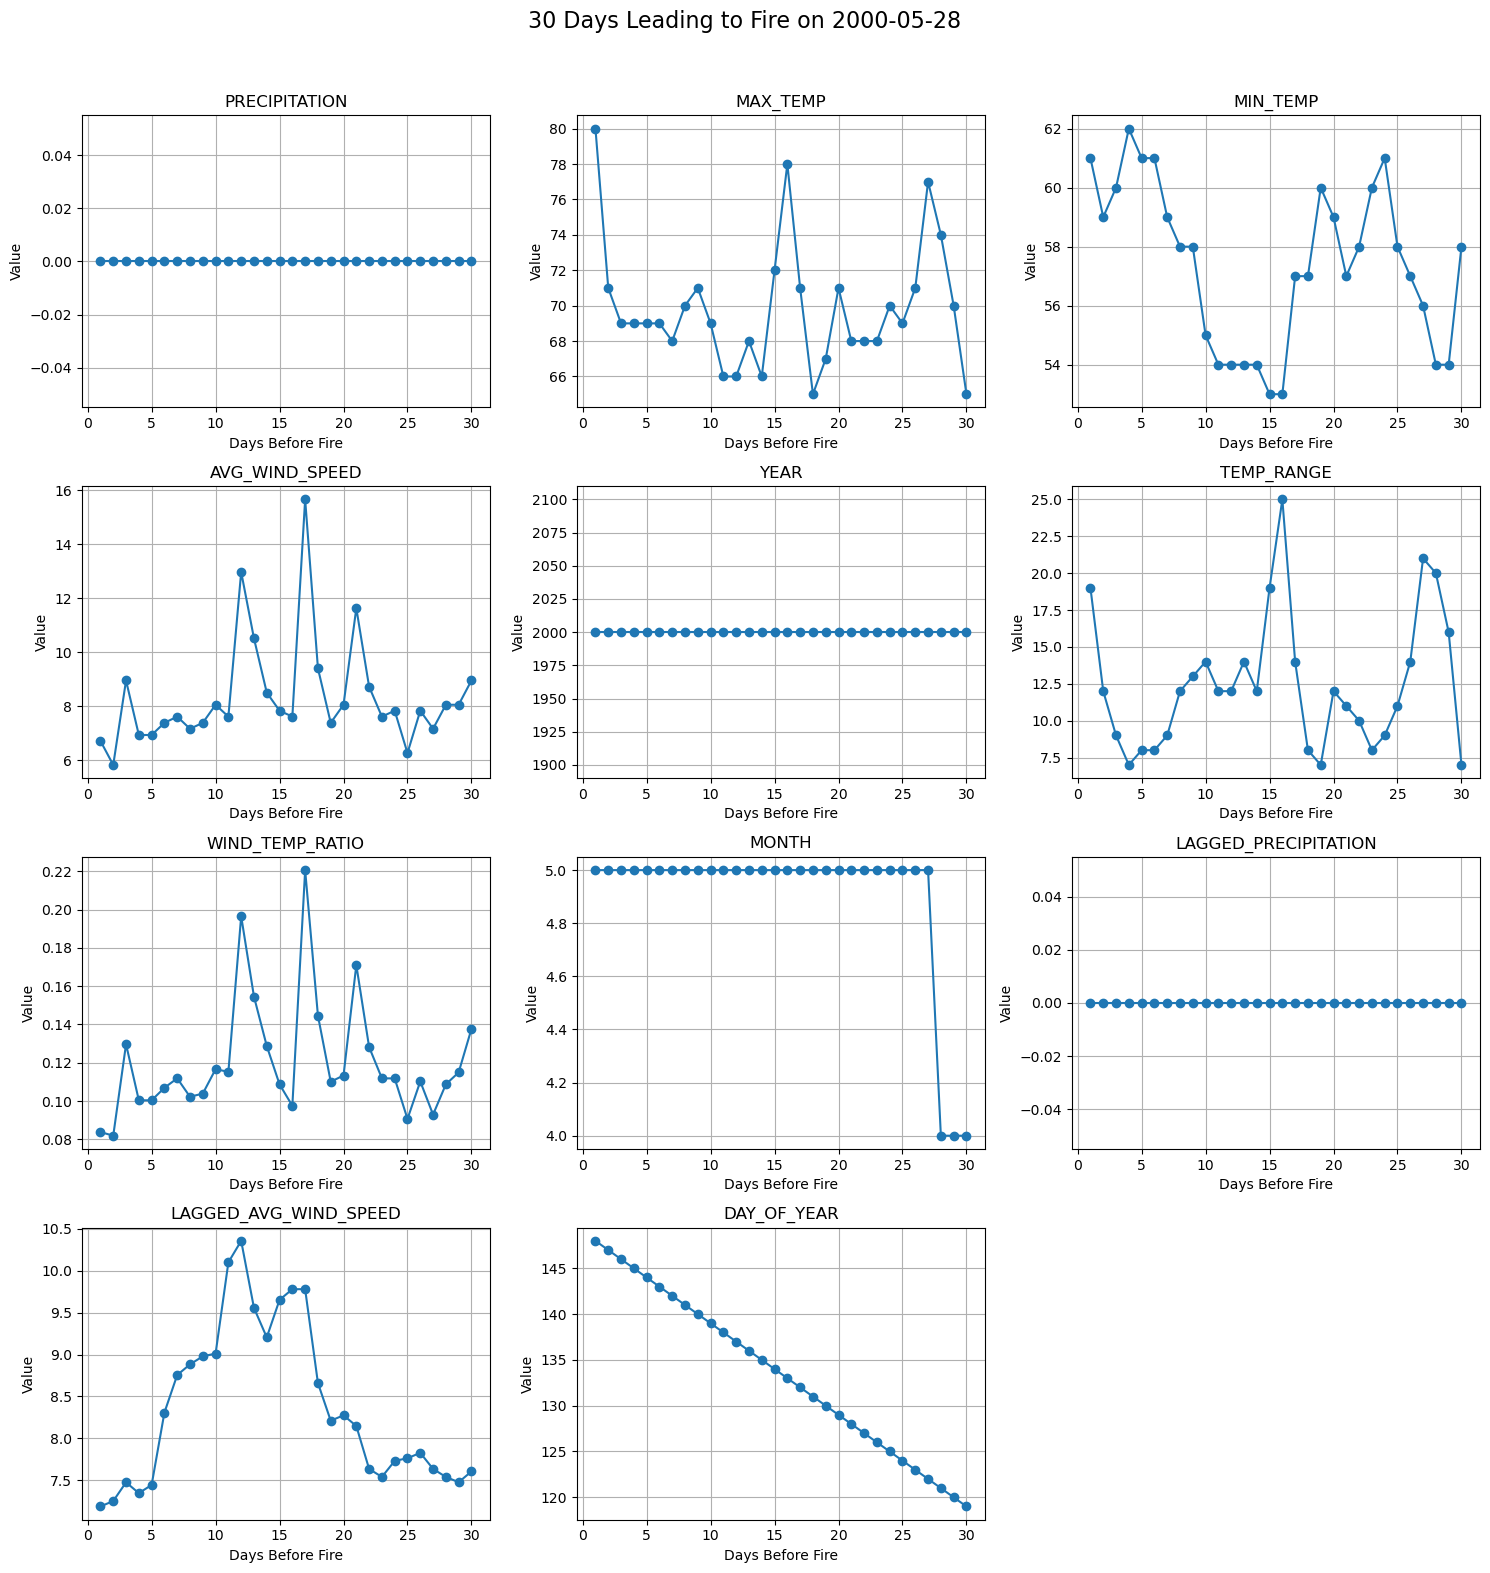

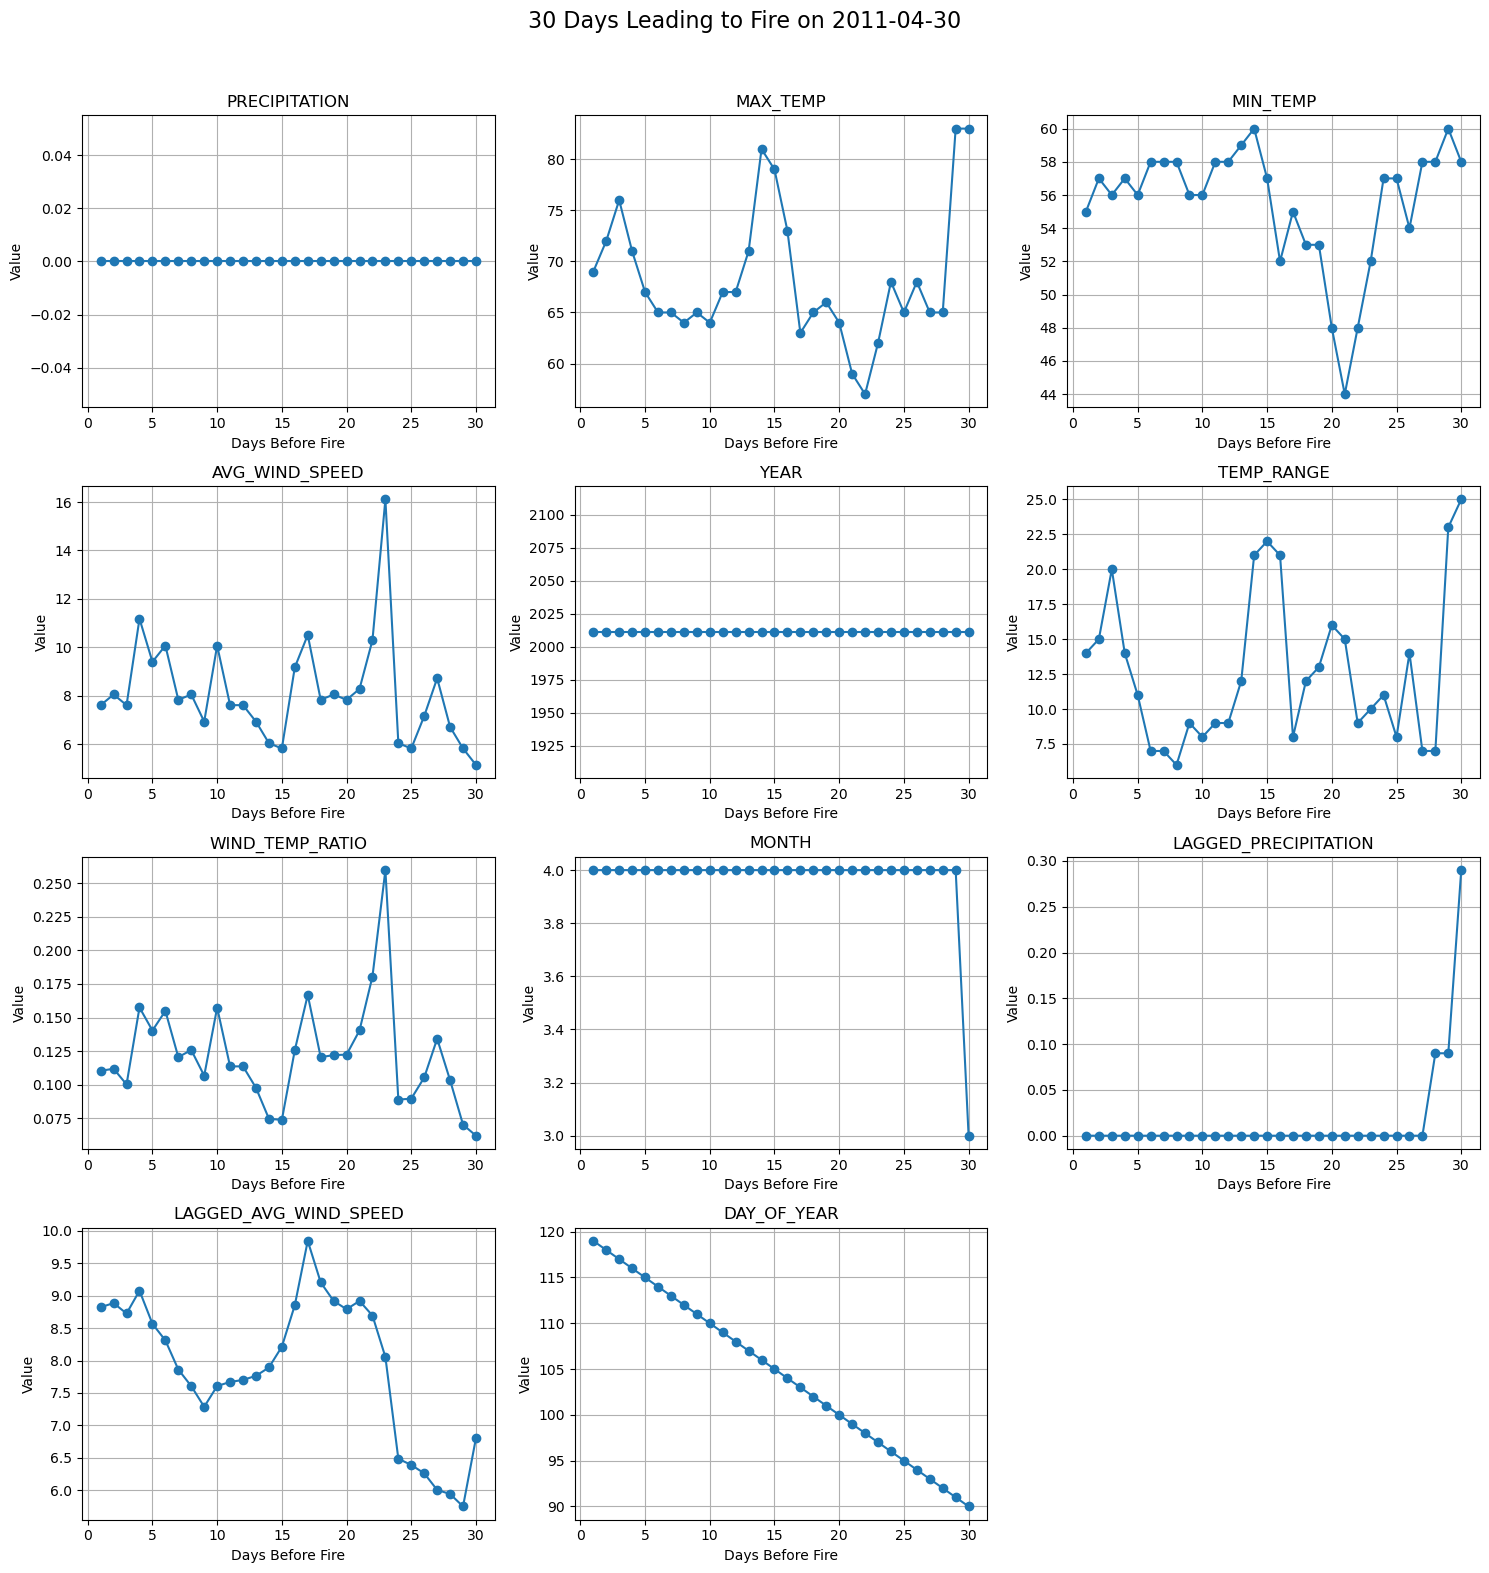

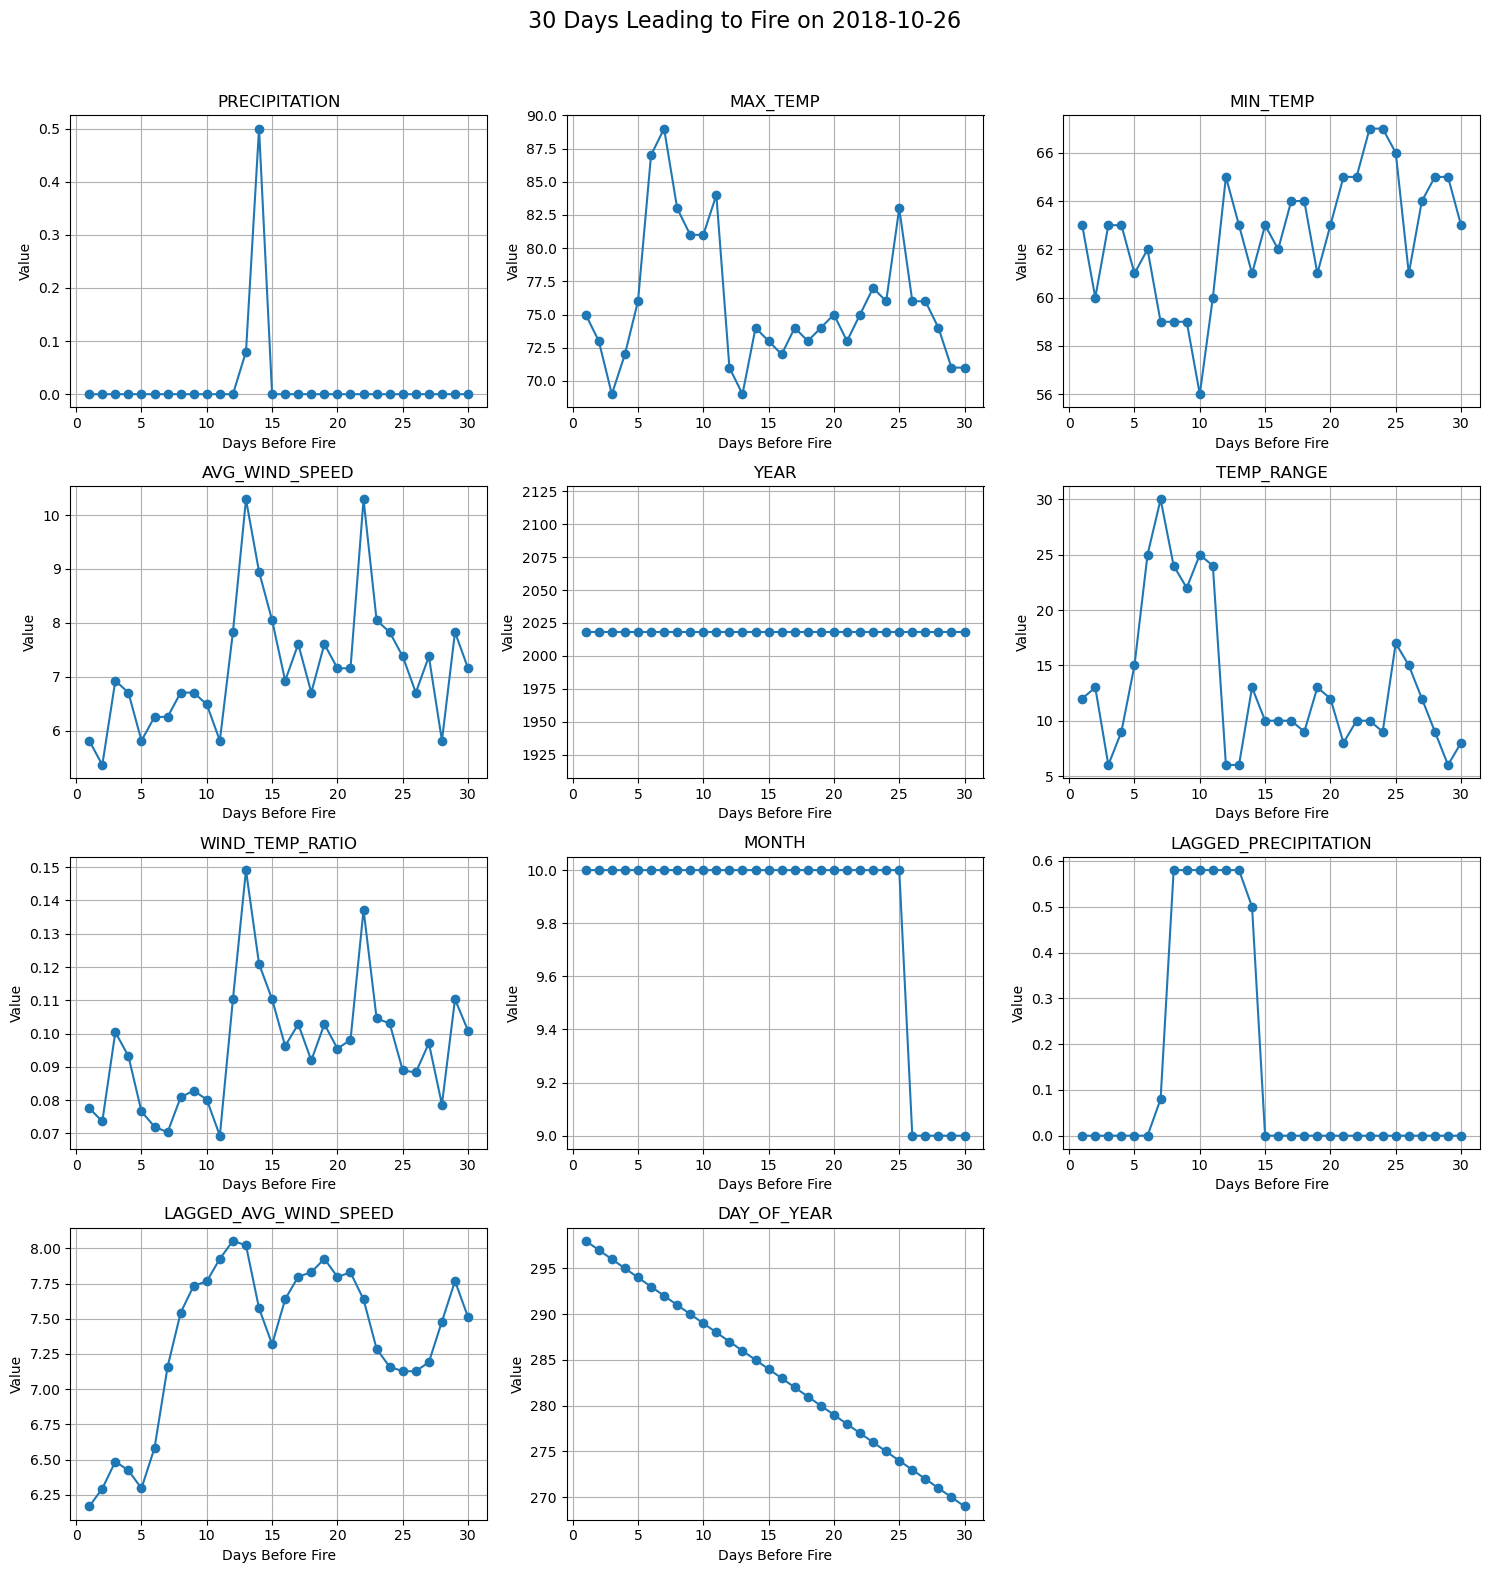

In [13]:
# Making a copy makes sure that the main dataset remains untouched
df_viz = df.copy()

# Ensure date is datetime and data is sorted
df_viz['DATE'] = pd.to_datetime(df_viz['DATE'])
df_viz = df_viz.sort_values('DATE')

# Make sure FIRE_START_DAY is boolean
df_viz['FIRE_START_DAY'] = df_viz['FIRE_START_DAY'].astype(bool)

# Choose a few sample fire events (e.g., 3 random ones)
sample_fire_dates = df_viz[df_viz['FIRE_START_DAY']].sample(n=3, random_state=42)['DATE']

# List of numerical features
feature_names = df_viz.select_dtypes(include='number').columns.tolist()
window_size = 30

# For each fire, plot the 30-day feature history
for i, fire_date in enumerate(sample_fire_dates):
    window = df_viz[(df_viz['DATE'] < fire_date) & (df_viz['DATE'] >= fire_date - pd.Timedelta(days=window_size))].copy()
    
    if len(window) < window_size:
        continue  # Skip incomplete windows
    
    window['Days Before Fire'] = (fire_date - window['DATE']).dt.days
    window = window.sort_values('Days Before Fire')  # So 30 → 1
    
    # Plot in a grid
    n_cols = 3
    n_rows = (len(feature_names) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
    axes = axes.flatten()
    
    for j, feature in enumerate(feature_names):
        ax = axes[j]
        ax.plot(window['Days Before Fire'], window[feature], marker='o')
        ax.set_title(feature)
        ax.set_xlabel("Days Before Fire")
        ax.set_ylabel("Value")
        ax.grid(True)
    
    for k in range(len(feature_names), len(axes)):
        fig.delaxes(axes[k])
    
    fig.suptitle(f"30 Days Leading to Fire on {fire_date.date()}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

**30 Days Before 05-28-2000 Fire:**
- Precipitation: 0
- Max_temp: Fluctuates. The day before the fire is significantly hotter
- Min_temp: Fluctuates. Where there is a drop around 15 days before the fire.
- Avg_wind_speed: Fluctuates. Wind speed is at peak around 15 days before the fire.
- Temp_range: Fluctuates. Peak is around 15 days before a fire.
- Wind_temp_ratio: Fluctuates. Peakrs are around 15-20 days before the fire.
- Lagged_precipitation: 0
- Lagged_avg_wind_speed: Bell-curve. Peak is 10-15 days before the fire.

**30 Days Before 04-30-2011 Fire:**

- Precipitation: 0
- Max_temp: Fluctuates. 15 days prior to the fire is peak. There is a dip in temperature around 20-25 days before the fire.
- Min_temp: Fluctuates. Where there is a drop around 20 days before the fire.
- Avg_wind_speed: Fluctuates. Wind speed is at peak around 20 days before the fire.
- Temp_range: Fluctuates. Peak is around 15 days before a fire
- Wind_temp_ratio: Fluctuates. Peakrs are around 20-25 days before the fire.
- Lagged_precipitation: 0, but can happen 25 days before a fire 
- Lagged_avg_wind_speed: Bell-curve. Peak is 10-15 days before the fire

**30 Days Before 10-26-2018 Fire:**
- Precipitation: Some rain 15 days before the fire
- Max_temp: Fluctuates. Drops 10-20 days before the fire.
- Min_temp: Fluctuates. Drops 10 days before a fire
- Avg_wind_speed: Fluctuates. Wind speed is at peak around 15 and 25 days before the fire.
- Temp_range: Fluctuates. Peak is around 5 days before a fire, but there is also a significant drop 10-15 days before
- Wind_temp_ratio: Fluctuates. Peakrs are around 10-15 days before the fire.
- Lagged_precipitation: Usually 0 but can even happen a week before a fire
- Lagged_avg_wind_speed: Highest around 10 days before

**IMPORTANT TRENDS I'VE NOTICED**
- Indicators happen 1-2 weeks before a fire start where, temperatures seem to drop and wind speeds increase. Why?
    - Cold air brings drier winds and dries out vegetation

## **Data Cleaning and Preparation for Machine Learning (LSTM)**

**DataFrame BEFORE Cleaning**

In [14]:
df.head(5)

,DATE,PRECIPITATION,MAX_TEMP,MIN_TEMP,AVG_WIND_SPEED,FIRE_START_DAY,YEAR,TEMP_RANGE,WIND_TEMP_RATIO,MONTH,SEASON,LAGGED_PRECIPITATION,LAGGED_AVG_WIND_SPEED,DAY_OF_YEAR
0,1/1/84,0.0,79.0,51.0,4.70,False,1984,28.0,0.059494,1,Winter,0.0,4.700,1
1,1/2/84,0.0,71.0,46.0,5.59,False,1984,25.0,0.078732,1,Winter,0.0,5.145,2
2,1/3/84,0.0,70.0,47.0,5.37,False,1984,23.0,0.076714,1,Winter,0.0,5.220,3
3,1/4/84,0.0,76.0,45.0,4.70,False,1984,31.0,0.061842,1,Winter,0.0,5.090,4
4,1/5/84,0.0,74.0,49.0,5.14,False,1984,25.0,0.069459,1,Winter,0.0,5.100,5


**Handle Missing Values**

In [16]:
df.isnull().sum()

DATE                      0
PRECIPITATION             1
MAX_TEMP                  1
MIN_TEMP                  1
AVG_WIND_SPEED           12
FIRE_START_DAY            0
YEAR                      0
TEMP_RANGE                1
WIND_TEMP_RATIO          12
MONTH                     0
SEASON                    0
LAGGED_PRECIPITATION      0
LAGGED_AVG_WIND_SPEED     0
DAY_OF_YEAR               0
dtype: int64

Here we have the choice of just removing the rows with missing values or imputing. I would like to impute because these rows could be the rows that are the outliers and in our case, we'd want to keep the outliers and extreme conditions so our model can learn from them. Plus, there aren't a lot of extreme values our model can learn from so it would be beneficial information to keep. For numerical features, we can fill it with mean/median depending on the distribution of the data. There are no missing categorical data so that's fine.

In [17]:
# See row with missing information
missing_precipitation = df[df['PRECIPITATION'].isnull()]
missing_precipitation

,DATE,PRECIPITATION,MAX_TEMP,MIN_TEMP,AVG_WIND_SPEED,FIRE_START_DAY,YEAR,TEMP_RANGE,WIND_TEMP_RATIO,MONTH,SEASON,LAGGED_PRECIPITATION,LAGGED_AVG_WIND_SPEED,DAY_OF_YEAR
14975,12/31/24,NaN,NaN,NaN,NaN,False,2024,NaN,NaN,12,Winter,0.0,4.92,366


In [18]:
# Impute based on disribution 

# Precipitation: impute zeros
df['PRECIPITATION'].fillna(0, inplace=True) 
# This makes sense because lagged precipitation for the week is 0, anyways

# For normally distributed features, use mean
for col in ['MAX_TEMP', 'MIN_TEMP', 'AVG_WIND_SPEED', 'WIND_TEMP_RATIO']:
    df[col].fillna(df[col].mean(), inplace=True)

# For skewed feature, use median (temp range is right-skewed)
df['TEMP_RANGE'].fillna(df['TEMP_RANGE'].median(), inplace=True)

**Encode Boolean and Categorical Variables**

For this part, we can either encode using **one-hot**, **label**, or **cyclical**. For LSTM, we should use cyclical because LSTMs learn patterns over sequences. Using cyclical encoding, the LSTM sees the cyclical features as smooth, continuous cycles, not broken numeric jumps. 
- This helps the model understand that after day 365, day 1 follows, or that Fall loops back to Winter.
- This prevents the model from learning incorrect discontinuities in time-based data.

In [19]:
# Encode target variable boolean

df['FIRE_START_DAY'] = df['FIRE_START_DAY'].map({'False': 0, 'True': 1}).astype(int)

In [20]:
# Cyclical encoding for SEASON
season_mapping = {'Winter': 0, 'Spring': 1, 'Summer': 2, 'Fall': 3}
df['SEASON_NUM'] = df['SEASON'].map(season_mapping)
df['SEASON_SIN'] = np.sin(2 * np.pi * df['SEASON_NUM'] / 4)
df['SEASON_COS'] = np.cos(2 * np.pi * df['SEASON_NUM'] / 4)
df = df.drop(columns=['SEASON', 'SEASON_NUM'])

# Cyclical encoding for DAY_OF_YEAR
max_day = 366
df['DAY_SIN'] = np.sin(2 * np.pi * df['DAY_OF_YEAR'] / max_day)
df['DAY_COS'] = np.cos(2 * np.pi * df['DAY_OF_YEAR'] / max_day)
df = df.drop(columns=['DAY_OF_YEAR'])

**Move Target Variable to the End**

In [21]:
# Move 'FIRE_START_DAY' to the end
cols = [col for col in df.columns if col != 'FIRE_START_DAY'] + ['FIRE_START_DAY']
df = df[cols]

**Clean and Format Date**

In [22]:
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.sort_values('DATE')

**Drop Redundant/Unneeded Features**

To help identify redundant and unneeded features, we can use a correlation matrix and anything that has a high correlation r-value, we can take one out.

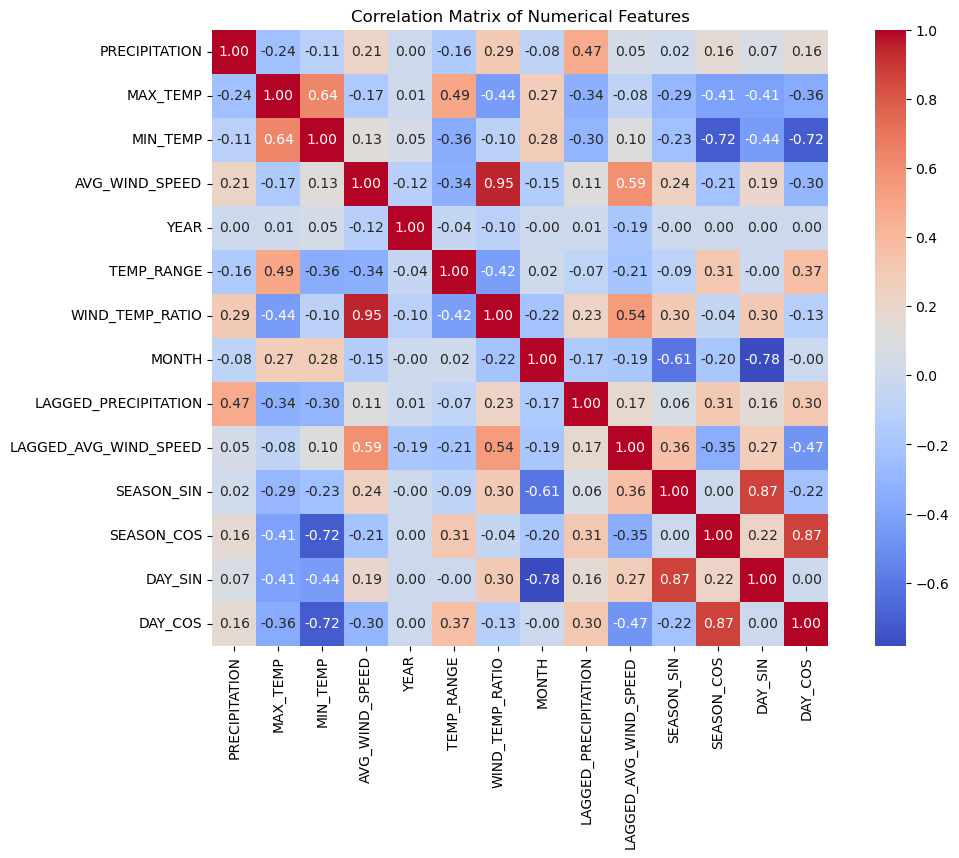

In [23]:
# Correlation of numerical feaetures

numeric_cols = ['PRECIPITATION', 'MAX_TEMP', 'MIN_TEMP', 'AVG_WIND_SPEED', 'YEAR', 'TEMP_RANGE', 'WIND_TEMP_RATIO', 'MONTH',
    'LAGGED_PRECIPITATION', 'LAGGED_AVG_WIND_SPEED', 'SEASON_SIN', "SEASON_COS", "DAY_SIN", "DAY_COS"]

plt.figure(figsize=(12, 8))
corr = df[numeric_cols].corr()

sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

In [24]:
# List out the strong correlation pairs

corr_matrix = df[numeric_cols].corr().abs()

# This is to avoid duplicates (select just the upper triangle of the matrix)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find pairs with correlation >= 0.5 (can adjust this threshold if needed)
strong_corrs = upper.stack().reset_index()
strong_corrs.columns = ['Feature 1', 'Feature 2', 'Correlation']
strong_corrs = strong_corrs[strong_corrs['Correlation'] >= 0.5]
strong_corrs = strong_corrs.sort_values(by='Correlation', ascending=False).reset_index(drop=True)

print(strong_corrs)

         Feature 1              Feature 2  Correlation
0   AVG_WIND_SPEED        WIND_TEMP_RATIO     0.950775
1       SEASON_SIN                DAY_SIN     0.872466
2       SEASON_COS                DAY_COS     0.872159
3            MONTH                DAY_SIN     0.782334
4         MIN_TEMP             SEASON_COS     0.717137
5         MIN_TEMP                DAY_COS     0.715650
6         MAX_TEMP               MIN_TEMP     0.636894
7            MONTH             SEASON_SIN     0.614545
8   AVG_WIND_SPEED  LAGGED_AVG_WIND_SPEED     0.594199
9  WIND_TEMP_RATIO  LAGGED_AVG_WIND_SPEED     0.544005


Multicollinearity can prove to be an issue depending on the models that will be used in this pipeline. Logistic regression is very sensitive to multicollinearity so ideally, we would want to address this by either getting rid of or combining the features that are highly correlated (> 0.8). LSTM is more robust to multicollinearity, but it is still good to take out a feature to avoid redundancy. It makes sense that these values are correlated because day of year corresponds to the month, average wind speeds depend on the wind that day, higher max temperatures usually also mean higher minimum temperatures, etc. So we will address this issue of multicollinearity later during pre-processing and feature engineering.

In [25]:
# Drop the features. We can mess around with wind temp ratio later to see if it is helpful to our data

df = df.drop(columns=['MONTH', 'DATE', 'WIND_TEMP_RATIO']) 

In [26]:
df.columns

Index(['PRECIPITATION', 'MAX_TEMP', 'MIN_TEMP', 'AVG_WIND_SPEED', 'YEAR',
       'TEMP_RANGE', 'LAGGED_PRECIPITATION', 'LAGGED_AVG_WIND_SPEED',
       'SEASON_SIN', 'SEASON_COS', 'DAY_SIN', 'DAY_COS', 'FIRE_START_DAY'],
      dtype='object')

**Rescale/Normalize**

For LSTM, we should Normalize our data.

In [27]:
# Features to normalize (exclude cyclical sin/cos and target)
to_normalize = [
    'PRECIPITATION', 'MAX_TEMP', 'MIN_TEMP', 'AVG_WIND_SPEED',
    'YEAR', 'TEMP_RANGE', 'LAGGED_PRECIPITATION', 'LAGGED_AVG_WIND_SPEED']

scaler = MinMaxScaler()
df[to_normalize] = scaler.fit_transform(df[to_normalize])

**DataFrame AFTER Cleaning**

In [28]:
df.head(5)

,PRECIPITATION,MAX_TEMP,MIN_TEMP,AVG_WIND_SPEED,YEAR,TEMP_RANGE,LAGGED_PRECIPITATION,LAGGED_AVG_WIND_SPEED,SEASON_SIN,SEASON_COS,DAY_SIN,DAY_COS,FIRE_START_DAY
0,0.0,0.517857,0.409091,0.119360,0.0,0.666667,0.0,0.137577,0.0,1.0,0.017166,0.999853,0
1,0.0,0.375000,0.295455,0.155865,0.0,0.589744,0.0,0.179143,0.0,1.0,0.034328,0.999411,0
2,0.0,0.357143,0.318182,0.146842,0.0,0.538462,0.0,0.186149,0.0,1.0,0.051479,0.998674,0
3,0.0,0.464286,0.272727,0.119360,0.0,0.743590,0.0,0.174006,0.0,1.0,0.068615,0.997643,0
4,0.0,0.428571,0.363636,0.137408,0.0,0.589744,0.0,0.174940,0.0,1.0,0.085731,0.996318,0


In [29]:
# SAVE CLEANED DATAFRAME FOR MACHINE LEARNING USE LATER
df.to_csv('firedf_cleaned.csv', index=False)